# CS 445 Final Project: Video/Image Upsamling

### Setup

In [1]:
datadir = "./" 

utilfn = datadir + "utils.py"
imagesfn = datadir + "images"

In [2]:
import ffmpeg
import cv2
import numpy as np
import os
import numpy.linalg as la
import utils
%matplotlib inline
from matplotlib import pyplot as plt

from random import random
import time
import scipy
import scipy.ndimage as nd
import seaborn as sns
import pandas as pd
import scipy.sparse.linalg
from scipy import optimize
import pwlf

# Image Upsamling

### Read input image

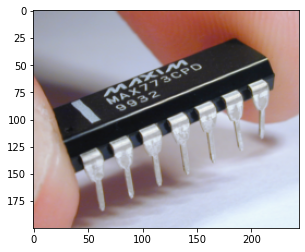

In [7]:
input_img_location = imagesfn + '/chip_input.png'
im1 = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure()
plt.imshow(im1)

## 1. Initial Up-Sample using fast bicubic interpolation

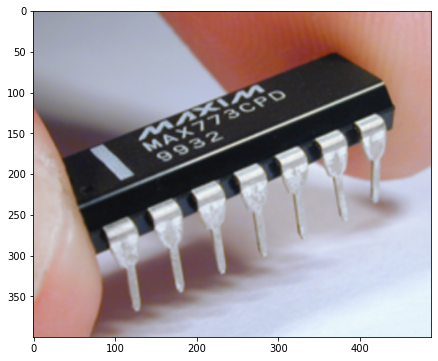

In [8]:
bicubic_im1 = cv2.resize(im1, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(8, 6))
plt.imshow(bicubic_im1)

## 2. Feedback-control upsamling

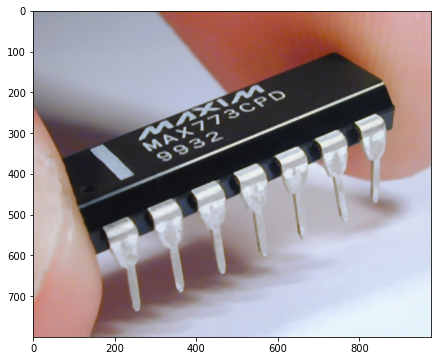

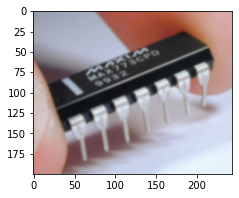

In [519]:
## test if method works using kernel we give
expect_loc = imagesfn + "/chip_10iter_s2.0_deconv0.03.png"
expect_im = cv2.cvtColor(cv2.imread(expect_loc), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure(figsize=(8, 6))
plt.imshow(expect_im)

# blur and down sample expect image using known kernal
sigma = 2
ksize = int(np.ceil(sigma)*6+1)
fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
fil = fil*np.transpose(fil)

down_sample_result = cv2.resize(cv2.filter2D(H, -1, fil), None, fx=0.5, fy=0.5)
plt.figure(figsize=(4, 3))
plt.imshow(down_sample_result)

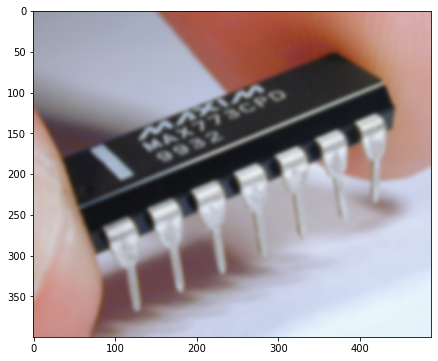

In [520]:
im1 = down_sample_result.copy()
bicubic_im1 = cv2.resize(im1, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(8, 6))
plt.imshow(bicubic_im1)

## Deconvolution
***
### Compute image gradient density 

In [521]:
def compute_gradient(img):
#     f1 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
#     f2 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]]).T
    f1 = np.array([[-1], [0], [1]])
    f2 = np.array([[-1, 0, 1]])
    vert_gradient = cv2.filter2D(img, -1, f1)
    horz_gradient = cv2.filter2D(img, -1, f2)
    gradient = np.sqrt(np.square(vert_gradient) + np.square(horz_gradient))
    return gradient

In [522]:
gradient = compute_gradient(im1)
gradR = gradient[:,:,0]
gradG = gradient[:,:,1]
gradB = gradient[:,:,2]

In [523]:
gradR_norm = cv2.normalize(gradR, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
gradR_norm = gradR_norm.astype(np.uint8)

In [524]:
gradR_norm

array([[0, 1, 1, ..., 1, 3, 0],
       [3, 3, 4, ..., 1, 3, 0],
       [4, 4, 4, ..., 1, 3, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

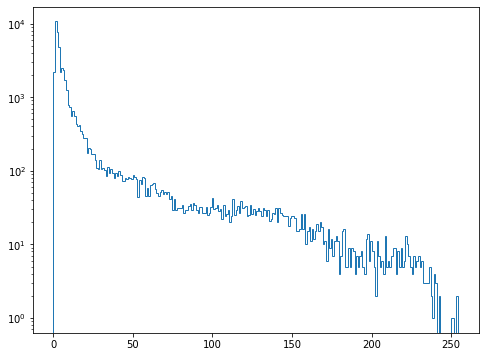

In [525]:
flatten_gradR = gradR_norm.flatten()
plt.figure(figsize=(8, 6))
counts, bins, bars = plt.hist(r, log=True, bins=256,range=(0,255),facecolor="r", histtype = 'step')
plt.show()

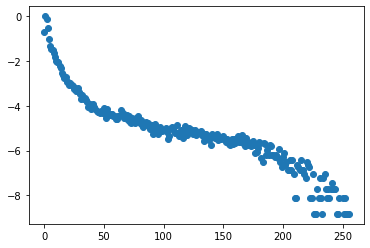

In [526]:
df = pd.Series(flatten_gradR).value_counts().reset_index()
df.columns = ['val', 'count']
val = np.array(df['val'])
log_count = np.log(df['count'] / df['count'].max())
plt.scatter(val, log_count)
plt.show()

In [527]:
my_pwlf = pwlf.PiecewiseLinFit(val, log_count)
breaks = my_pwlf.fit(2)
print(breaks)
l_t = breaks[1]

[  0.          23.67295466 255.        ]


In [528]:
def piecewise(x, k, a, b):
    return np.piecewise(x, [x <= l_t, x > l_t], [lambda x: -k*abs(x), lambda x: -1 * (a * (x ** 2) + b)])

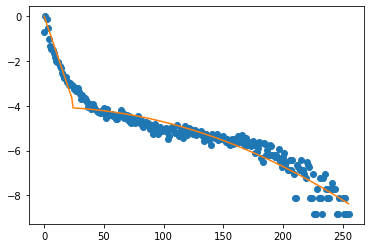

In [529]:
p , e = optimize.curve_fit(piecewise, val, log_count)
xd = np.linspace(0, 255, len(df['count']))
plt.plot(val,  log_count, "o")
plt.plot(xd, piecewise(xd, *p))
plt.show()

In [530]:
k, a, b = p[0], p[1], p[2]
print("k={:.10f}, a={:.10f}, b={:.10f}: ".format(k, a, b))

k=0.1574764016, a=0.0000664352, b=4.0544647277: 


In [531]:
def phi(x, l_t, k, a, b):
    if abs(x) <= l_t:
        return -k * abs(x)
    return -(a * x**2 + b)

In [532]:
def calculate_phi(gradient):
    l_t_arr = np.zeros(3)
    k_arr = np.zeros(3)
    a_arr = np.zeros(3)
    b_arr = np.zeros(3)
    for i in range(3):
        grad = gradient[:,:,i]
        grad_norm = cv2.normalize(grad, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
        grad_norm = grad_norm.astype(np.uint8)
        flatten_grad = grad_norm.flatten()
        df = pd.Series(flatten_grad).value_counts().reset_index()
        df.columns = ['val', 'count']
        val = np.array(df['val'])
        log_count = np.log(df['count'] / df['count'].max())
        my_pwlf = pwlf.PiecewiseLinFit(val, log_count)
        breaks = my_pwlf.fit(2)
        l_t = breaks[1]
        p , e = optimize.curve_fit(piecewise, val, log_count)
        l_t_arr[i] = l_t
        k_arr[i], a_arr[i], b_arr[i] = p[0], p[1], p[2]
    return l_t_arr, k_arr, a_arr, b_arr
        

In [533]:
l_t_arr, k_arr, a_arr, b_arr = calculate_phi(gradient)

### Minimize Energy function

In [534]:
H_prime = bicubic_im1.copy()

sigma = 2
ksize = int(np.ceil(sigma)*6+1)
fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
fil = fil*np.transpose(fil)

s1 = np.array(H_prime.shape[:2])
s2 = np.array(fil.shape)
size = s1 + s2 - 1

fsize = 2 ** np.ceil(np.log2(size)).astype(int)
fslice = tuple([slice(0, int(sz)) for sz in size])

# only compute filter and H_prime fft once
f_fft = np.fft.fft2(fil , fsize)
f_fft = f_fft[:,:,np.newaxis]
H_prime_fft = np.fft.fftn(H_prime, (fsize[0],fsize[1], 3))



In [535]:
H = H_prime.copy()  # assume gaussian filter does nothing
f1 = np.array([[-1], [0], [1]])
f2 = np.array([[-1, 0, 1]])
H_x_gradient = cv2.filter2D(H, -1, f1)
H_y_gradient = cv2.filter2D(H, -1, f2)

lambda_1 = 0.3
lambda_2 = 20


In [536]:
H_x_gradient.max()

0.24642899858348738

- $\mu$ Step: fix$H$to optimize $\mu$
$$ E(\mu) = \lambda_1\parallel \Phi(\mu_x) \parallel_1 + \ \lambda_2\parallel \mu_x - \partial_x H \parallel_2^{2}$$
***
$$ \partial_x H \geq l_t : E(\mu) = \lambda_1| -k|\mu_x| | + \lambda_2 (\mu_x - \partial_x H)^2$$
***
$$ \partial_x H < l_t : E(\mu) = \lambda_1| -(a \mu_x^2 + b) | + \lambda_2 (\mu_x - \partial_x H)^2$$
***
By solving $\partial E(\mu)/ \partial \mu = 0$, we have
$$ \partial H \geq l_t : \mu = \frac{2 \lambda_2 \partial H \pm \lambda_1 k}{2 \lambda_2}$$
***
$$ \partial H < l_t : \mu = \frac{2 \lambda_2 \partial H}{2 \lambda_1 a + 2 \lambda_2}$$

In [537]:
# 𝜇 step
def mu_optimize(l_t_arr, k_arr, a_arr, b_arr, lambda_1, lambda_2, H_x_gradient, H_y_gradient):
    mu_x = np.zeros(H_x_gradient.shape)
    mu_y = np.zeros(H_y_gradient.shape)
    height,width = H_x_gradient.shape[:2]

    for c in range(3):
        l_t = l_t_arr[c]
        # since input of phi is between 0 and 255
        k = k_arr[c] * 255
        a = a_arr[c] * (255**2)
        b = b_arr[c]
        for i in range(height):
            for j in range(width):
                curr_x_grad = H_x_gradient[i, j, c]
                curr_y_grad = H_y_gradient[i, j, c]
                
                if abs(curr_x_grad) >= l_t:
                    if curr_x_grad > 0:
                        mu_x[i,j,c] = ((2 * lambda_2 * curr_x_grad) - lambda_1 * k) / (2 * lambda_2)
                    else:
                        mu_x[i,j,c] = ((2 * lambda_2 * curr_x_grad) + lambda_1 * k) / (2 * lambda_2)
                else:
                    mu_x[i,j,c] = (2 * lambda_2 * curr_x_grad) / (2 * lambda_1 * a + 2 * lambda_2)
                
                if abs(curr_y_grad) >= l_t:
                    if curr_y_grad > 0:
                        mu_y[i,j,c] = ((2 * lambda_2 * curr_y_grad) - lambda_1 * k) / (2 * lambda_2)
                    else:
                        mu_y[i,j,c] = ((2 * lambda_2 * curr_y_grad) + lambda_1 * k) / (2 * lambda_2)
                else:
                    mu_y[i,j,c] = (2 * lambda_2 * curr_y_grad) / (2 * lambda_1 * a + 2 * lambda_2)
    
    return mu_x, mu_y
                

In [538]:
mu_x, mu_y = mu_optimize(l_t_arr, k_arr, a_arr, b_arr, lambda_1, lambda_2, H_x_gradient, H_y_gradient)

In [539]:
(mu_x - H_x_gradient).max()

0.013468836417056429

- $H$ Step: fix$\mu$ to minimize$H$
$$ E(H) = \ \parallel f \otimes H - \tilde{H} \parallel_2^{2} + \ \lambda_2(\parallel \mu_x - \partial_x H \parallel_2^{2} + \parallel \mu_y - \partial_y H \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (9)$$
Using Plancherel’s theorem:
$$ E(H) = \ \parallel \mathcal{F}(f) \circ \mathcal{F}(H) - \mathcal{F}(\tilde{H}) \parallel_2^{2} + \ \lambda_2(\parallel \mathcal{F}(\mu_x) - \mathcal{F}(\partial_x) \circ \mathcal{F}(H) \parallel_2^{2} + \parallel \mathcal{F}(\mu_y) - \mathcal{F}(\partial_y) \circ \mathcal{F}(H) \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (10)$$

By setting $\partial E(H)/ \partial F(H) = 0$, we obtain an optimal $\mathcal{F}^{*}(H)$ that minimize $E(H)$:

$$
\mathcal{F}^{*}(H) = \frac
{\overline{\mathcal{F}(f)} \circ \mathcal{F}(\tilde{H}) + \lambda_2 \overline{\mathcal{F}(\partial_x)} \circ \mathcal{F}(\mu_x) + \lambda_2 \overline{\mathcal{F}(\partial_y)} \circ \mathcal{F}(\mu_y)}
{\overline{\mathcal{F}(f)} \circ \mathcal{F}(f) + \lambda_2 \overline{\mathcal{F}(\partial_x)} \circ \mathcal{F}(\partial_x) + \lambda_2 \overline{\mathcal{F}(\partial_y)} \circ \mathcal{F}(\partial_y)}
$$

where $\overline{(.)}$ is the conjucate operator and $\mathcal{F}$ is FFT operation.

Finally, $ H^{*} = \mathcal{F}^{-1}(\mathcal{F}^{*}(H)) $

In [540]:
def H_optimize(f_fft, H_prime_fft, fsize, fslice, lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y):
    H_x_grad_fft = np.fft.fftn(H_x_gradient, (fsize[0],fsize[1], 3))
    H_y_grad_fft = np.fft.fftn(H_y_gradient, (fsize[0],fsize[1], 3))
    mu_x_fft = np.fft.fftn(mu_x, (fsize[0],fsize[1], 3))
    mu_y_fft = np.fft.fftn(mu_y, (fsize[0],fsize[1], 3))
    H_star_fft = (np.conj(f_fft) * H_prime_fft + lambda_2 * np.conj(H_x_grad_fft) * mu_x_fft + 
                  lambda_2 * np.conj(H_y_grad_fft) * mu_y_fft) / (np.conj(f_fft) * f_fft + 
                  lambda_2 * np.conj(H_x_grad_fft) * H_x_grad_fft + lambda_2 * np.conj(H_y_grad_fft) * H_y_grad_fft)
    H_star = np.fft.ifftn(H_star_fft)[fslice]
    H_star = H_star / H_star.max()
    H_star = np.clip(np.real(H_star),0,1)
    
    x_pad = int((H_star.shape[0] - mu_x.shape[0]) / 2)
    y_pad = int((H_star.shape[1] - mu_x.shape[1]) / 2)
    H_star = H_star[x_pad:-x_pad, y_pad:-y_pad,:]
    return H_star

In [541]:
H_star = H_optimize(f_fft, H_prime_fft,fsize, fslice, lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y)

In [542]:
H_star.max()

0.0034187911325339088

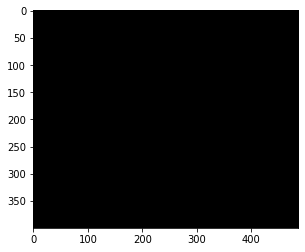

In [544]:
plt.figure()
plt.imshow(H_star)

In [489]:
for i in range(4):
    lambda_2 *= 3
    H = H_star.copy()
    H_x_gradient = cv2.filter2D(H, -1, f1)
    H_y_gradient = cv2.filter2D(H, -1, f2)
    mu_x, mu_y = mu_optimize(l_t_arr, k_arr, a_arr, b_arr, lambda_1, lambda_2, H_x_gradient, H_y_gradient)
    H_star = H_optimize(f_fft, H_prime_fft,fsize, fslice, lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y)

## Re-convolution

## Pixel Substitution

## 3. Final Output

# Video Upsamling